In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.init as init
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

/Users/minerva/Desktop/BlackBird/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [151]:
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [152]:
# from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('csv/forest_train.csv')

# scaler = MinMaxScaler(feature_range=(-1, 1))
numuric_cols = data.columns[1:-1]
# data[numuric_cols] = scaler.fit_transform(data[numuric_cols])

MAX_VAL = 8329
data[numuric_cols] = data[numuric_cols] / MAX_VAL

data

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,2002,0.035178,0.231360,0.124625,0.033377,0.057030,0.054388,0.118502,0.212871,0.262216,0.228119,0.281306,0.364870,MDF
1,3212,0.023652,0.191860,0.083684,0.024133,0.041662,0.027374,0.081883,0.237964,0.294033,0.270621,0.322368,0.322968,DDF
2,13312,0.111538,0.237123,0.123784,0.117901,0.122464,0.102773,0.146476,0.246248,0.290671,0.287189,0.320687,0.322128,MDF
3,17020,0.015848,0.187297,0.082723,0.022692,0.048985,0.021011,0.073118,0.254172,0.349021,0.363069,0.360788,0.354784,MDF
4,5967,0.028935,0.233401,0.135791,0.043463,0.064594,0.058470,0.110217,0.185977,0.221395,0.204346,0.249370,0.245288,MDF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13048,9185,0.044903,0.232921,0.126546,0.045864,0.067835,0.059791,0.117301,0.201465,0.231600,0.253212,0.275063,0.252131,DDF
13049,13977,0.238084,0.432465,0.326570,0.194741,0.213951,0.212030,0.277824,0.418778,0.468243,0.471125,0.491896,0.726738,DDF
13050,755,0.112859,0.240965,0.137832,0.117061,0.129667,0.116220,0.150318,0.213711,0.238084,0.233161,0.269780,0.260535,DDF
13051,1616,0.140953,0.277584,0.142874,0.133509,0.135190,0.106736,0.157282,0.301477,0.370393,0.366190,0.407732,0.405811,MDF


In [204]:
# Training Parameters
num_features = len(numuric_cols)
noise_dim = 100
lr = 0.0002

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Model Initialization
generator = Generator(noise_dim, num_features)
discriminator = Discriminator(num_features)

if device != 'cpu':
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    print(f'move to {device}')

# Define Loss Function & Optimizer
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

mps
move to mps


In [187]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'input': torch.tensor(self.data[idx]),
        }
        return sample

In [188]:
# Select Target Class to Generate
target_col = 'nforest_type'
target_class = 'DEF'

train_df = data[data[target_col]==target_class].drop(['id', target_col], axis=1)
train_df

,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9
7,0.084164,0.213231,0.107456,0.082723,0.108657,0.082123,0.142514,0.300636,0.340497,0.340857,0.380838,0.372554
8,0.018730,0.134590,0.065674,0.031696,0.056669,0.043463,0.083924,0.200864,0.236163,0.261976,0.271341,0.273382
10,0.064353,0.191019,0.093289,0.082363,0.091247,0.074919,0.125945,0.258374,0.312162,0.319966,0.355865,0.333413
13,0.186217,0.182375,0.086205,0.207708,0.211790,0.181775,0.206387,0.272182,0.306639,0.311922,0.329331,0.329331
19,0.037580,0.203626,0.103734,0.043943,0.068195,0.049346,0.101933,0.235923,0.286589,0.292832,0.339416,0.331252
...,...,...,...,...,...,...,...,...,...,...,...,...
13014,0.021851,0.160403,0.068916,0.022572,0.035538,0.017409,0.068556,0.240125,0.296914,0.269300,0.346260,0.341458
13026,0.000120,0.210469,0.098451,0.012727,0.051747,0.036139,0.100852,0.251051,0.296794,0.331612,0.349862,0.292952
13037,0.033738,0.220555,0.100252,0.041061,0.086205,0.034218,0.117061,0.336295,0.426942,0.436667,0.456357,0.377957
13044,0.198823,0.234722,0.115860,0.215152,0.236763,0.214432,0.241686,0.291271,0.316605,0.308560,0.340857,0.339176


In [189]:
batch_size = 128

# Create DataLoader
dataset = MyDataset(train_df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [205]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)


# Load Pretrain or Train From Scratch
pretrained = False
save_path = 'model/forestGAN_DDF.pt'

if pretrained:
    pre_dict = torch.load(save_path)
    generator.load_state_dict(pre_dict['generator'])
    discriminator.load_state_dict(pre_dict['discriminator'])
else:
    generator = generator.apply(weights_init)
    discriminator = discriminator.apply(weights_init)

In [199]:
save_step = 100 # every 100 epochs
num_epochs = 1000

for epoch in range(num_epochs):
    for batch in dataloader:
        real_data_batch = batch['input'].to(device)

        # Train Discriminator on Real Data
        real_labels = torch.FloatTensor(np.random.uniform(0.9, 1.0, (batch_size, 1))).to(device) # Real = 1
        disc_optimizer.zero_grad()
        output_real = discriminator(real_data_batch)
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()

        # Train Discriminator on Generated Data
        fake_labels = torch.FloatTensor(np.random.uniform(0, 0.1, (batch_size, 1))).to(device) # Fake = 0
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, noise_dim))).to(device)
        generated_data = generator(noise)
        output_fake = discriminator(generated_data.detach())
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()

        disc_optimizer.step()

        # Train Generator 
        valid_labels = torch.FloatTensor(np.random.uniform(0.9, 1.0, (batch_size, 1))).to(device) # Want to be Valid = 1
        gen_optimizer.zero_grad()
        output_g = discriminator(generated_data)
        loss_g = criterion(output_g, valid_labels)
        loss_g.backward()
        gen_optimizer.step()

    # Print progress
    print(f"Epoch {epoch}, D Loss Real: {loss_real.item()}, D Loss Fake: {loss_fake.item()}, G Loss: {loss_g.item()}")

    if (epoch+1) % save_step == 0:

        model_state = {
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict()
        }
        torch.save(model_state, save_path)

Epoch 0, D Loss Real: 0.6676130890846252, D Loss Fake: 0.7137480974197388, G Loss: 0.6626055240631104
Epoch 1, D Loss Real: 0.6700279116630554, D Loss Fake: 0.7118474245071411, G Loss: 0.6740444302558899
Epoch 2, D Loss Real: 0.6717549562454224, D Loss Fake: 0.7112216949462891, G Loss: 0.678250789642334
Epoch 3, D Loss Real: 0.6780962944030762, D Loss Fake: 0.7094042301177979, G Loss: 0.677355945110321
Epoch 4, D Loss Real: 0.6774845123291016, D Loss Fake: 0.7060360908508301, G Loss: 0.6824157238006592
Epoch 5, D Loss Real: 0.6837787628173828, D Loss Fake: 0.6989375948905945, G Loss: 0.6892683506011963
Epoch 6, D Loss Real: 0.6968607902526855, D Loss Fake: 0.6877986192703247, G Loss: 0.7042935490608215
Epoch 7, D Loss Real: 0.7006834745407104, D Loss Fake: 0.6936254501342773, G Loss: 0.6905392408370972
Epoch 8, D Loss Real: 0.6896786689758301, D Loss Fake: 0.7013343572616577, G Loss: 0.6865599155426025
Epoch 9, D Loss Real: 0.6367941498756409, D Loss Fake: 0.7123538255691528, G Loss: 0

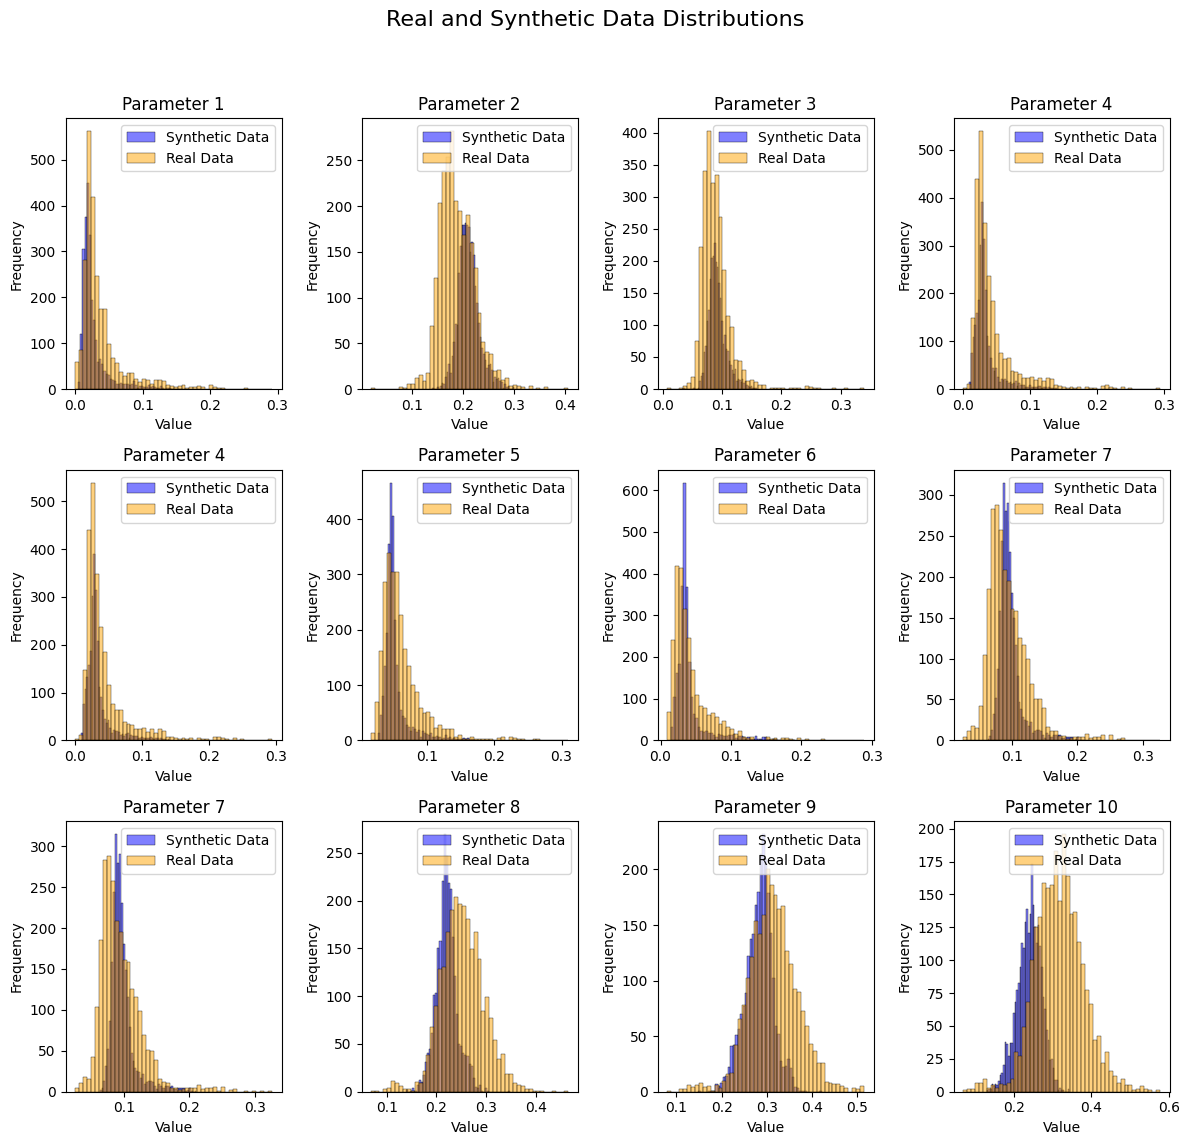

In [200]:
import seaborn as sns

# Generate synthetic data 
synthetic_data = generator(torch.FloatTensor(np.random.normal(0, 1, (train_df.shape[0], noise_dim))).to(device)).cpu()

# Plot the results
fig, axs = plt.subplots(3, 4, figsize=(12, 12))
fig.suptitle('Real and Synthetic Data Distributions', fontsize=16)

for i in range(3):
    for j in range(4):

        ith_feature = i * 3 + j
        if ith_feature >= len(numuric_cols):
            break

        bin_width = (1 - (-1)) / 20
        sns.histplot(synthetic_data[:, ith_feature].detach().numpy(), bins=50, alpha=0.5, label='Synthetic Data', ax=axs[i, j], color='blue')
        sns.histplot(train_df.values[:, ith_feature], bins=50, alpha=0.5, label='Real Data', ax=axs[i, j], color='orange')
        axs[i, j].set_title(f'Parameter {ith_feature + 1}', fontsize=12)
        axs[i, j].set_xlabel('Value')
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

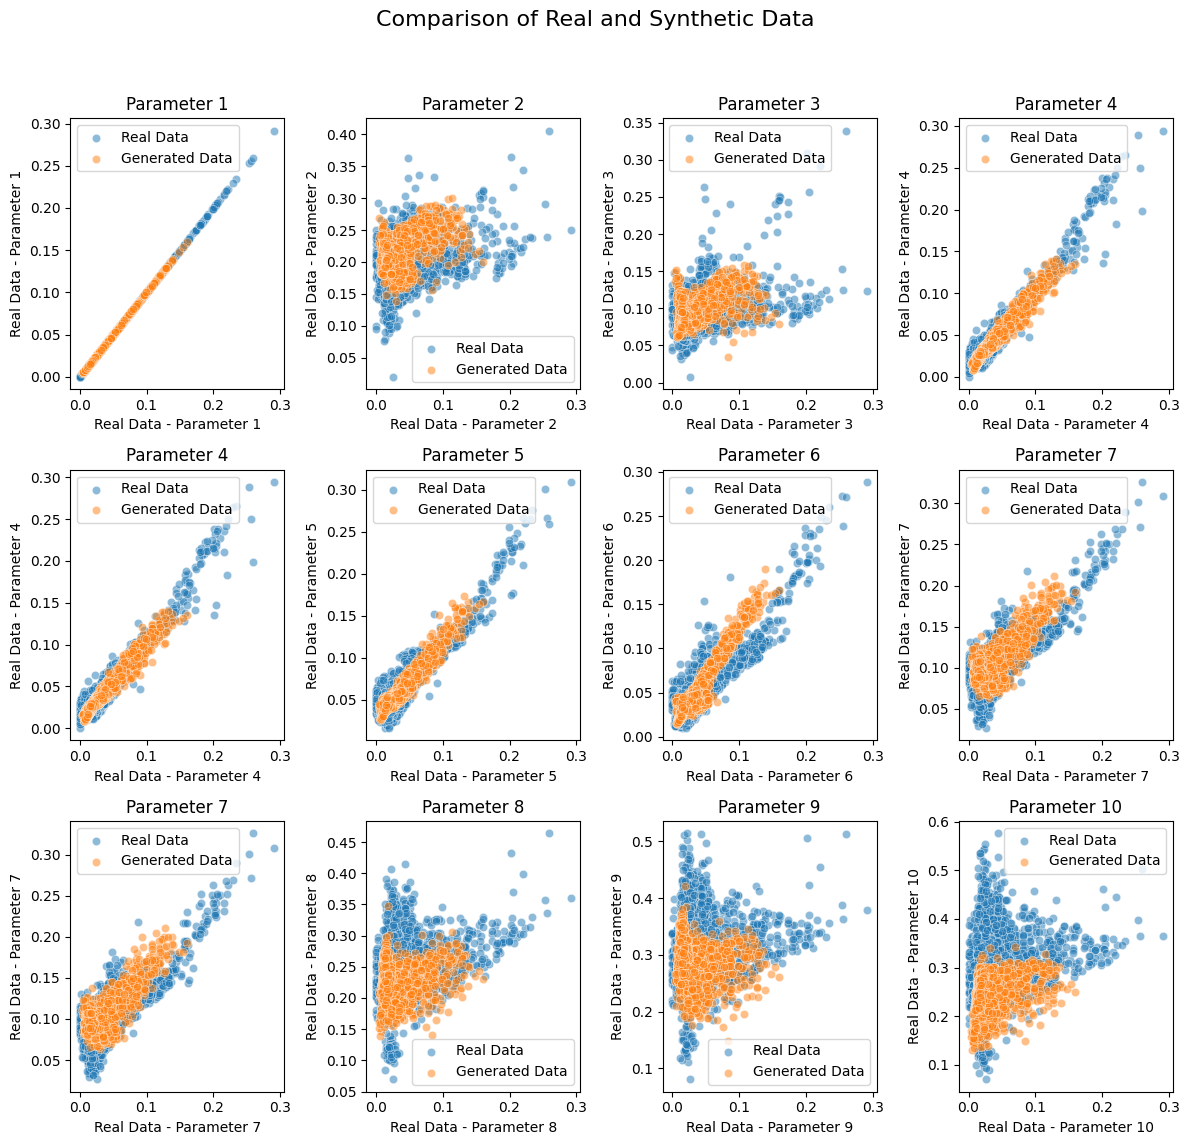

In [201]:
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(12, 12))
fig.suptitle('Comparison of Real and Synthetic Data', fontsize=16)

# Define parameter names
param_names = [f'Parameter {i+1}' for i in range(len(numuric_cols))]

# Scatter plots for each parameter
for i in range(3):
    for j in range(4):

        ith_feature = i * 3 + j
        if ith_feature >= len(numuric_cols):
            break

        sns.scatterplot(x=train_df.values[:, 0], y=train_df.values[:, ith_feature], label='Real Data', alpha=0.5, ax=axs[i, j])
        sns.scatterplot(x=synthetic_data[:, 0].detach().numpy(), y=synthetic_data[:, ith_feature].detach().numpy(), label='Generated Data', alpha=0.5, ax=axs[i, j])
        axs[i, j].set_title(param_names[ith_feature], fontsize=12)
        axs[i, j].set_xlabel(f'Real Data - {param_names[ith_feature]}')
        axs[i, j].set_ylabel(f'Real Data - {param_names[ith_feature]}')
        axs[i, j].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [206]:
n_gen = 10000
synthetic_data = generator(torch.FloatTensor(np.random.normal(0, 1, (n_gen, noise_dim))).to(device)).cpu()
synth_df = pd.DataFrame(synthetic_data.detach().numpy(), columns=['b1', 'b11', 'b12', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8_a', 'b9'])
synth_df['nforest_type'] = 'DEF'
synth_df

,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,0.122994,0.262233,0.147072,0.135370,0.164455,0.143343,0.167620,0.291596,0.338553,0.357088,0.345540,0.322486,DDF
1,0.030223,0.222176,0.085741,0.033897,0.068969,0.041925,0.089191,0.280874,0.312502,0.338391,0.348001,0.332268,DDF
2,0.031032,0.213958,0.092359,0.034575,0.071488,0.045724,0.095454,0.257119,0.299021,0.321846,0.330560,0.309734,DDF
3,0.069202,0.226773,0.113839,0.083914,0.109631,0.094391,0.128077,0.242986,0.284946,0.307900,0.302937,0.283234,DDF
4,0.110003,0.201231,0.109026,0.134874,0.153434,0.126571,0.153534,0.235334,0.282929,0.304215,0.267723,0.264990,DDF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.024132,0.191125,0.103194,0.032626,0.048389,0.053586,0.083453,0.165534,0.182207,0.216658,0.222943,0.216974,DDF
9996,0.087507,0.093620,0.045322,0.124428,0.170315,0.055617,0.099643,0.262377,0.371241,0.334921,0.197415,0.258882,DDF
9997,0.029866,0.230044,0.085505,0.033920,0.070837,0.042807,0.085557,0.283099,0.310074,0.342443,0.346750,0.326937,DDF
9998,0.022848,0.176793,0.075798,0.028027,0.056504,0.038911,0.073669,0.194225,0.233522,0.251072,0.249017,0.257741,DDF


In [207]:
synth_df.to_csv('synth_data_DEF.csv', index=False)